In [2]:
import sys, os
sys.path.append('..')
from Data.TimeSeries import *

from Data import factors
import Quandl
import pandas as pd
import matplotlib

import cvxopt as opt
from cvxopt import blas, solvers


%matplotlib inline

## 0. downloading data
Download the ETF data

In [39]:
sector_tickers = ['GOOG/NYSEARCA_XLB',
           'GOOG/NYSEARCA_XLE', 
           'GOOG/NYSEARCA_XLF',
           'GOOG/NYSEARCA_XLI',
           'GOOG/NYSEARCA_XLK',
           'GOOG/NYSEARCA_XLP', 
           'GOOG/NYSEARCA_XLU', 
           'GOOG/NYSEARCA_XLV', 
           'GOOG/NYSEARCA_XLY']



settings = Settings()
dp = TimeSeries(settings).get_agg_data(sector_tickers)
dp

<class 'pandas.core.panel.Panel'>
Dimensions: 9 (items) x 4342 (major_axis) x 6 (minor_axis)
Items axis: GOOG/NYSEARCA_XLB to GOOG/NYSEARCA_XLY
Major_axis axis: 1998-12-22 00:00:00+00:00 to 2016-03-08 00:00:00+00:00
Minor_axis axis: open to price

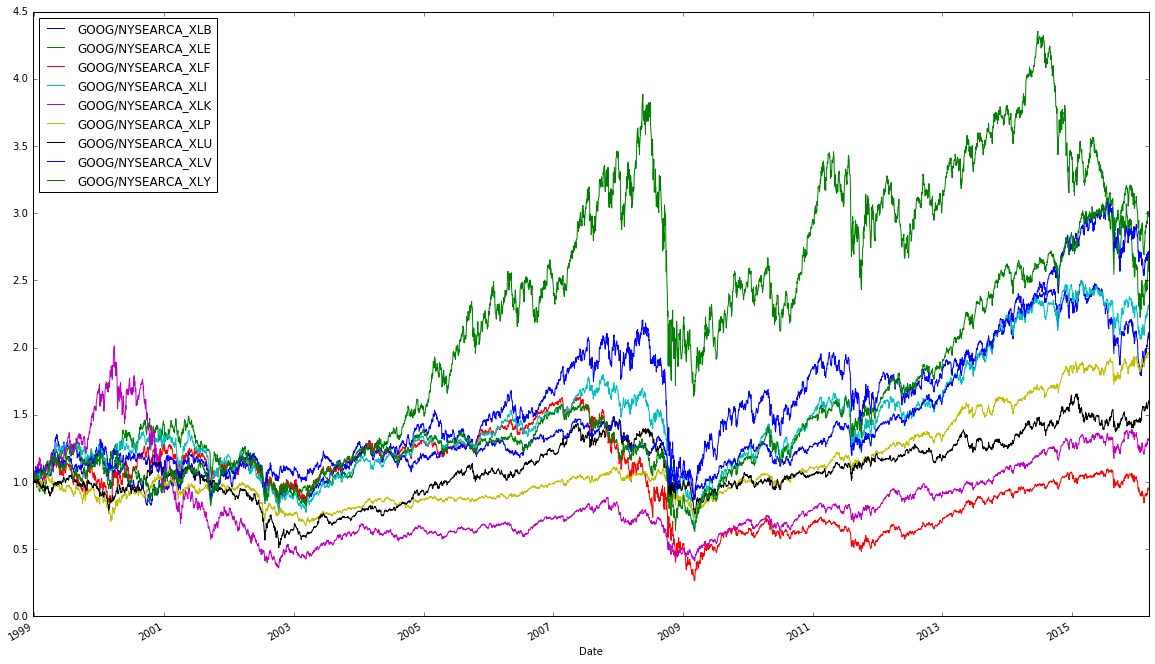

In [40]:
dp = dp.fillna(method='pad', axis=0)
dp = dp.fillna(method='bfill', axis=0)
#dp = dp[:,'2008-01-01'::,:]
#dp[:, :,'price'].plot(figsize=[20,10])
df_rets = dp[:,:,'price'].pct_change().dropna()
(1+df_rets).cumprod().plot(figsize=[20,12])

# Adaptive Asset Allocation (AAA)

In [41]:
import numpy as np
import zipline 
from zipline.api import (add_history, history, set_slippage, 
                         slippage, set_commission, commission, 
                         order_target_percent) 

from zipline import TradingAlgorithm 

def initialize(context): 
    ''' Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables. The context object 
    is passed to all the other methods in your algorithm. Parameters context: 
    An initialized and empty Python dictionary that has been augmented so 
    that properties can be accessed using dot notation as well as the 
    traditional bracket notation. Returns None ''' 
    #Register history container to keep a window of the last 100 prices. 
    add_history(100, '1d', 'price') 
    # Turn off the slippage model 
    set_slippage(slippage.FixedSlippage(spread=0.0)) 
    # Set the commission model (Interactive Brokers Commission) 
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
    context.tick = 0
    
def handle_data(context, data): 
    ''' Called when a market event occurs for any of the algorithm's securities. 
    Parameters data: A dictionary keyed by security id containing the current 
    state of the securities in the algo's universe. context: The same context 
    object from the initialize function. Stores the up to date portfolio as 
    well as any state variables defined. Returns None ''' 
    # Allow history to accumulate 100 days of prices before trading 
    # and rebalance every day thereafter. 
    context.tick += 1 
    if context.tick < 100: 
        return 
    if context.tick % 60 != 0:
        return 
    
    
    # Get rolling window of past prices and compute returns 
    prices = history(100, '1d', 'price').dropna() 
    returns = prices.pct_change().dropna() 
    try: 
        # Perform Markowitz-style portfolio optimization 
        weights, _, _ = optimal_portfolio(returns.T) 
        # Rebalance portfolio accordingly 
        for stock, weight in zip(prices.columns, weights): 
            order_target_percent(stock, weight) 
    except ValueError as e: 
        # Sometimes this error is thrown 
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
        pass

##  1.  10 assets, Equal Weight, Rebalanced Monthly


In [42]:
ret_ports = pd.DataFrame()

In [43]:
class AAA:
    def __init__(self, data) :
        self.data = data
    
    def initialize(self, context) :
        pass
    
    def handle_data(self, context, data) :
        pass
    
    def run_trading(self) :
        algo = TradingAlgorithm(initialize=self.initialize, handle_data=self.handle_data)
        results = algo.run(self.data)
        return results

In [44]:
class Portfolio1(AAA): 
        
    def average_weights(self, returns): 
        n = len(returns) 
        wt = opt.matrix(1.0/n, (n, 1))
        return np.asarray(wt)

    def initialize(self, context):
        add_history(30, '1d', 'price') 
        set_slippage(slippage.FixedSlippage(spread=0.005)) 
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
        context.tick = 0
        
    def handle_data(self, context, data): 
        rebalance_period = 20

        context.tick += 1 
        if context.tick % rebalance_period != 0:
            return 


        # Get rolling window of past prices and compute returns 
        prices = history(30, '1d', 'price').dropna() 
        returns = prices.pct_change().dropna() 
        try: 
            # Perform Markowitz-style portfolio optimization 
            weights = self.average_weights(returns.T) 
            # Rebalance portfolio accordingly 
            for stock, weight in zip(prices.columns, weights): 
                order_target_percent(stock, weight) 
        except ValueError as e: 
            # Sometimes this error is thrown 
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
            pass

In [45]:
results = Portfolio1(dp.dropna()).run_trading()
ret_ports[1] = results.portfolio_value

IndexError: index 0 is out of bounds for axis 0 with size 0

## Portfolio 2: Equal Volatility Weight, Rebalanced Monthly
with the 10 assets. Each asset has 1% daily vol (60 days moving vol). And no asset has over 10% of the portfolio 

In [ ]:
class Portfolio2(AAA):
       
    def vol_weighting(self, returns): 
        n = len(returns)
        weight_target = 1.0 / n

        vol = np.std(returns, axis=1)
        vol_target = 0.01 # daily vol 1% target

        wt = vol_target / vol * weight_target
        wt[wt > weight_target] = weight_target
        return np.asarray(wt)

    def initialize(self, context):
        add_history(60, '1d', 'price') 
        set_slippage(slippage.FixedSlippage(spread=0.0)) 
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
        context.tick = 0

    def handle_data(self, context, data): 
        rebalance_period = 20

        context.tick += 1 
        if context.tick % rebalance_period != 0:
            return 


        # Get rolling window of past prices and compute returns 
        prices = history(60, '1d', 'price').dropna() 
        returns = prices.pct_change().dropna() 
        try: 
            # Perform Markowitz-style portfolio optimization 
            weights = self.vol_weighting(returns.T) 
            # Rebalance portfolio accordingly 
            for stock, weight in zip(prices.columns, weights): 
                order_target_percent(stock, weight) 
        except ValueError as e: 
            # Sometimes this error is thrown 
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
            pass

In [ ]:
results = Portfolio2(dp.dropna()).run_trading()
ret_ports[2] = results.portfolio_value
ret_ports.plot(figsize=[20, 12])

## Portfolio 3: Top 5 in 6 month momentum, each position = 20%


In [ ]:
class Portfolio3(AAA) :
    def MOM(self, returns): 
        mom = returns.sum(axis=1)
        wt = (mom > np.median(mom)) * 0.2
        return np.asarray(wt)

    def initialize(self, context):
        add_history(120, '1d', 'price') 
        set_slippage(slippage.FixedSlippage(spread=0.0)) 
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
        context.tick = 0

    def handle_data(self, context, data): 
        rebalance_period = 20

        context.tick += 1 
        if context.tick % rebalance_period != 0:
            return 


        # Get rolling window of past prices and compute returns 
        prices = history(120, '1d', 'price').dropna() 
        returns = prices.pct_change().dropna() 
        try: 
            # Perform Markowitz-style portfolio optimization 
            weights = self.MOM(returns.T) 
            # Rebalance portfolio accordingly 
            for stock, weight in zip(prices.columns, weights): 
                order_target_percent(stock, weight) 
        except ValueError as e: 
            # Sometimes this error is thrown 
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
            pass

In [ ]:
results = Portfolio3(dp.dropna()).run_trading()
ret_ports[3] = results.portfolio_value
ret_ports.plot(figsize=[20,12])

## Portfolio 4:  Top 1/2 Momentum, with equal vol weighting

In [ ]:
class Portfolio4(AAA) :
    def initialize(self, context):
        add_history(120, '1d', 'price') 
        set_slippage(slippage.FixedSlippage(spread=0.0)) 
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
        context.tick = 0

    def handle_data(self, context, data): 
        rebalance_period = 20

        context.tick += 1 
        if context.tick % rebalance_period != 0:
            return 


        # Get rolling window of past prices and compute returns 
        prices_6m = history(120, '1d', 'price').dropna() 
        returns_6m = prices_6m.pct_change().dropna() 
        prices_60d = history(60, '1d', 'price').dropna()
        returns_60d = prices_60d.pct_change().dropna()

        try: 
            # Get the strongest 5 in momentum
            mom = returns_6m.T.sum(axis=1)
            selected = (mom > np.median(mom)) * 1

            # 60 days volatility 
            vol = np.std(returns_60d.T, axis=1)
            vol_target = 0.01
            wt = vol_target / vol * 0.2
            wt[wt > 0.2] = 0.2
            #
            weights = wt * selected
            # Rebalance portfolio accordingly 
            for stock, weight in zip(prices_60d.columns, weights): 
                order_target_percent(stock, weight) 
        except ValueError as e: 
            # Sometimes this error is thrown 
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
            pass

In [ ]:
results = Portfolio4(dp.dropna()).run_trading()
ret_ports[4] = results.portfolio_value
ret_ports.plot(figsize=[20,12])

## Portfolio 5: Minimize Vol 
construct a portfolio with the minimal vol. 

In [33]:
from cvxpy import *

class Portfolio5(AAA) :
    def minimize_vol(self,returns): 
        n = len(returns) 
        w  = Variable(n)

        gamma = Parameter(sign='positive')
        mu = returns.mean(axis=1)
        ret = np.array(mu)[np.newaxis] * w

        Sigma = np.cov(returns)
        risk = quad_form(w, Sigma)
        prob = Problem(Maximize(ret - 200*risk), [sum_entries(w)==1, w >=0])
        prob.solve()
        #print w.value.T * Sigma * w.value
        return np.asarray(w.value)

    def initialize(self, context):
        add_history(120, '1d', 'price') 
        set_slippage(slippage.FixedSlippage(spread=0.0)) 
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
        context.tick = 0

    def handle_data(self, context, data): 
        rebalance_period = 20

        context.tick += 1 
        if context.tick < 120 : 
            return
        if context.tick % rebalance_period != 0:
            return 


        # Get rolling window of past prices and compute returns 
        prices_6m = history(120, '1d', 'price').dropna() 
        returns_6m = prices_6m.pct_change().dropna() 
        prices_60d = history(60, '1d', 'price').dropna()
        returns_60d = prices_60d.pct_change().dropna()

        try: 
            # Get the strongest 5 in momentum
            mom = returns_6m.T.sum(axis=1)
            #selected_indices = mom[mom>0].order().tail(len(mom) /2).index
            selected_indices = mom.index
            #selected_indices = mom[mom > 0 ].index
            selected_returns = returns_60d[selected_indices]

            weights = self.minimize_vol(selected_returns.T)
    #         weights = minimize_vol(returns_60d.T)
            # Rebalance portfolio accordingly 
            for stock, weight in zip(selected_returns.columns, weights): 
                order_target_percent(stock, weight) 
        except : 
            # Sometimes this error is thrown 
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
            pass

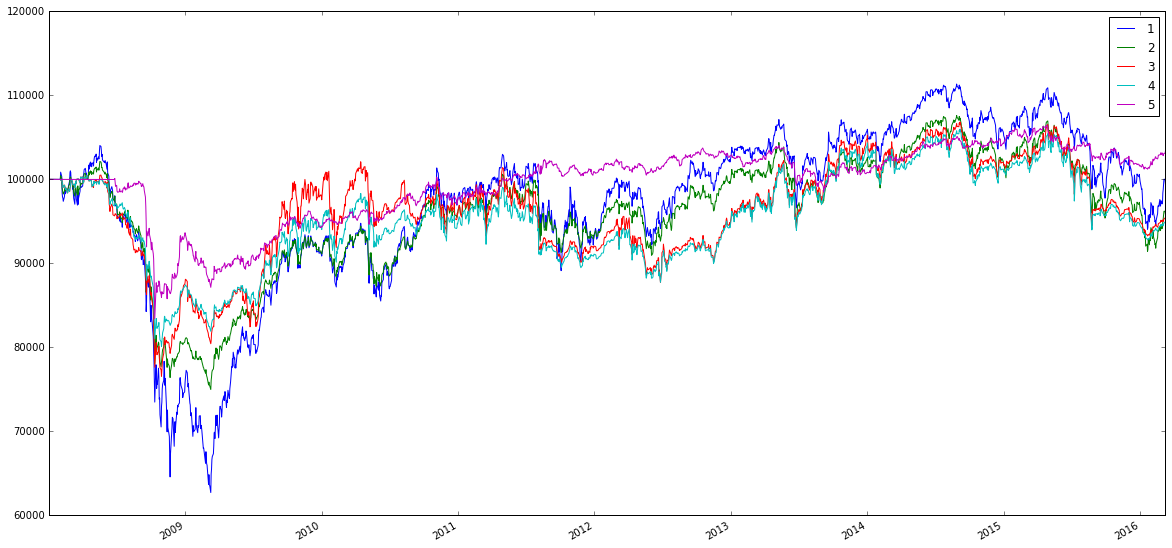

In [34]:
results = Portfolio5(dp.dropna()).run_trading()
ret_ports[5] = results.portfolio_value
ret_ports.plot(figsize=[20,10])

## Portfolio 6: modified momentum


In [35]:
class Portfolio6(AAA) :
    def minimize_vol(self,returns): 
        n = len(returns) 
        w  = Variable(n)

        gamma = Parameter(sign='positive')
        mu = returns.mean(axis=1)
        ret = np.array(mu)[np.newaxis] * w

        Sigma = np.cov(returns)
        risk = quad_form(w, Sigma)
        prob = Problem(Maximize(ret - 200*risk), [sum_entries(w)==1, w >=0])
        prob.solve()
        #print w.value.T * Sigma * w.value
        return np.asarray(w.value)

    def initialize(self, context):
        add_history(300, '1d', 'price') 
        set_slippage(slippage.FixedSlippage(spread=0.0)) 
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
        context.tick = 0

    def handle_data(self, context, data): 
        rebalance_period = 20

        context.tick += 1 
        if context.tick % rebalance_period != 0:
            return 


        # Get rolling window of past prices and compute returns 
        prices_3m = history(60, '1d', 'price').dropna()
        prices_6m = history(120, '1d', 'price').dropna()
        prices_12m = history(240, '1d', 'price').dropna()
        prices_60d = history(60, '1d', 'price').dropna()
        
        returns_3m = prices_3m.pct_change().dropna()
        returns_6m = prices_6m.pct_change().dropna()
        returns_12m = prices_12m.pct_change().dropna()
        returns_60d = prices_60d.pct_change().dropna()

        try: 
            # Get the strongest 5 in momentum
            rank_3m = returns_3m.T.sum(axis=1).rank(ascending=True)
            rank_6m = returns_6m.T.sum(axis=1).rank(ascending=True)
            rank_12m = returns_12m.T.sum(axis=1).rank(ascending=True)
            mom = rank_3m + rank_6m + rank_12m
            
            selected = (mom > np.median(mom)) * 1

            # 60 days volatility 
            vol = np.std(returns_60d.T, axis=1)
            vol_target = 0.01
            wt = vol_target / vol * 0.2
            wt[wt > 0.2] = 0.2
            #
            weights = wt * selected
            # Rebalance portfolio accordingly 
            for stock, weight in zip(prices_60d.columns, weights): 
                order_target_percent(stock, weight) 
        except ValueError as e: 
            # Sometimes this error is thrown 
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
            pass

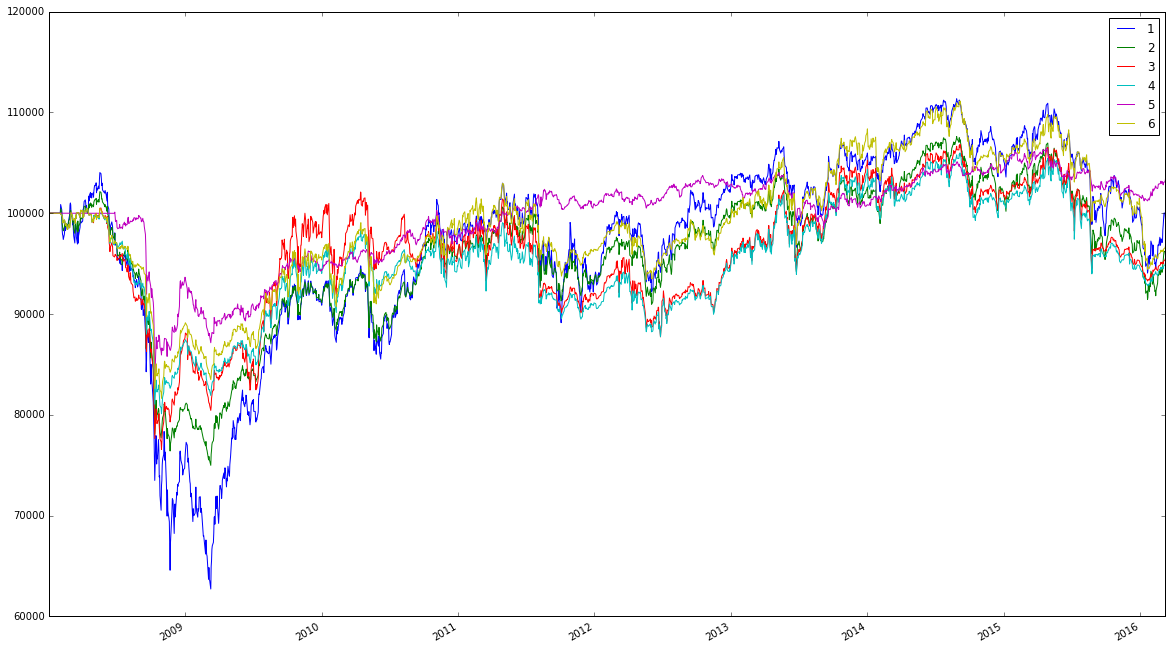

In [36]:
returns = Portfolio6(dp.dropna()).run_trading()
ret_ports[6] = returns.portfolio_value
ret_ports.plot(figsize=[20,12])

## Portfolio 7: Using MA as the filter, 

In [ ]:
class Portfolio7(AAA) :
    def minimize_vol(self,returns): 
        n = len(returns) 
        w  = Variable(n)

        gamma = Parameter(sign='positive')
        mu = returns.mean(axis=1)
        ret = np.array(mu)[np.newaxis] * w

        Sigma = np.cov(returns)
        risk = quad_form(w, Sigma)
        prob = Problem(Maximize(ret - 200*risk), [sum_entries(w)==1, w >=0])
        prob.solve()
        #print w.value.T * Sigma * w.value
        return np.asarray(w.value)

    def initialize(self, context):
        add_history(200, '1d', 'price') 
        set_slippage(slippage.FixedSlippage(spread=0.0)) 
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0)) 
        context.tick = 0

    def handle_data(self, context, data): 
        rebalance_period = 20

        context.tick += 1 
        if context.tick % rebalance_period != 0:
            return 


        # Get rolling window of past prices and compute returns 
        prices_1m = history(1, '1M', 'price').dropna()
        prices_10m = history(10, '1M', 'price').dropna()
        prices_200d = history(200, '1d', 'price').dropna()
        prices_60d = history(60, '1d', 'price').dropna()
        
        returns_60d = prices_60d.pct_change().dropna()

        try: 
            # Get the strongest 5 in momentum
            ma = np.mean(prices_10m)
            pr = np.mean(prices_1m)
            selected_indices = pr[pr < ma].index
            selected_returns = returns_60d[selected_indices]
            
            if len(selected_indices ) <= 1:
                return
                
            weights = self.minimize_vol(selected_returns.T)
           
            # Rebalance portfolio accordingly 
            for stock, weight in zip(selected_returns.columns, weights): 
                order_target_percent(stock, weight) 
        except ValueError as e: 
            # Sometimes this error is thrown 
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n 
            pass

In [ ]:
ret_ports[7] = Portfolio7(dp.dropna()).run_trading().portfolio_value
ret_ports.plot(figsize=[20, 10])

In [ ]:
ret_ports_ret = ret_ports.pct_change()
ret_str = ret_ports_ret * (ret_ports > ret_ports.shift(200)*1.07).shift(1)
(1+ret_str).cumprod().plot(figsize=[20,12])

In [ ]:
ret_ports.plot(figsize=[20,12])

In [6]:
prices = dp[:, :,'price']
df_m = prices
ticker_bm = 'GOOG/NYSEARCA_TLH'
df_benchmark = df_m[[ticker_bm]]
df_ret_12m = df_m / df_m.shift(240) - 1
df_ret_bm_12 = df_benchmark / df_benchmark.shift(240) - 1

df_ret = df_m.pct_change()

In [ ]:
df_str = (df_ret_12m[1] > df_ret_12m[ticker_bm]).shift(1) * df_ret_12m[[1]]

In [ ]:
df_str = (df_ret_12m > df_ret_12m[ticker_bm]).shift(1) * df_ret_12m
df_str1 = (df_ret_12m < df_ret_12m[ticker_bm]).shift(1) * df_ret_bm_12

#(1+df_str).cumprod().plot(figsize=[20,12])
(1+df_ret).cumprod().plot(figsize=[20,12])

In [ ]:
(1+df_str).cumprod().plot(figsize=[20,12])

In [ ]:
df_str

In [ ]:
selected_indices = prices_1d[prices_1d > ma].index
selected_rets = returns[selected_indices]
selected_rets

In [ ]:
returns = df_rets

price_1d = data.tail(1)


rank_3m = returns_3m.T.sum(axis=1).rank(ascending=True)
rank_6m = returns_6m.T.sum(axis=1).rank(ascending=True)
rank_12m = returns_12m.T.sum(axis=1).rank(ascending=True)
mom = rank_3m + rank_6m + rank_12m

selected = (mom > np.median(mom)) * 1

# 60 days volatility 
vol = np.std(returns_60d.T, axis=1)
vol_target = 0.01
wt = vol_target / vol * 0.2
wt[wt > 0.2] = 0.2
#
weights = wt * selected

In [ ]:
rank_3m = df_rets.T.sum(axis=1).rank(ascending=False)
rank_6m = df_rets.T.sum(axis=1).rank(ascending=False)
rank_12m = df_rets.T.sum(axis=1).rank(ascending=False)
mom = rank_3m + rank_6m + rank_12m
selected = (mom > np.median(mom)) * 1

In [ ]:
selected

In [ ]:
df_test = pd.DataFrame()
df_test['nav'] = ret_ports[4]
df_test['ma'] = pd.rolling_median(df_test['nav'], 20)
df_test['signal'] = (df_test['nav'] > df_test['ma']) * 1
df_test['ret'] = df_test['nav'].pct_change()
df_test['ret_st'] = df_test['ret'] * df_test['signal'].shift(1)

(1+df_test[['ret_st', 'ret']]).cumprod().plot(figsize=[20, 12])

### 弥财配置
我们现在试一试弥财选中的几个ETF， 是否可以通过同样的方法， 构建一个回报更高的投资组合

In [ ]:
from Data.TimeSeries import *

micai_tickers = ['GOOG/NYSE_VWO', 
                'GOOG/NYSE_VPL', 
                'GOOG/NYSE_VGK', 
                'GOOG/NYSE_VTI', 
                'GOOG/NYSE_IYR']
data  = TimeSeries(Settings()).get_agg_data(micai_tickers)
data = data.fillna(method='pad', axis=0)
data = data.fillna(method='bfill', axis=0)
data = data.dropna()

In [ ]:
data

In [ ]:
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data) 
# Run algorithm 
results = algo1.run(data)
results.portfolio_value.plot(figsize=[20,10])

algo2.run(data).portfolio_value.plot(figsize=[20,10])
algo4.run(data).portfolio_value.plot(figsize=[20,10])

# Correlation Checking

In [ ]:
def avg_corr(returns, size=20) :
    corrs = pd.rolling_corr(returns, 100)
    corrs = corrs.dropna()
    n = corrs.shape[1]
    avg_corr = (corrs.sum().sum() - n)/(n*(n-1))
    return avg_corr

df = pd.DataFrame()
df['ret'] = df_rets['GOOG/NYSE_SPY']
df['nav'] = (1+df['ret']).cumprod()
df['avg_corr'] = avg_corr(df_rets, 60)
df['ma_corr'] = pd.rolling_mean(df['avg_corr'], 30)
df['vol'] = pd.rolling_std(df['ret'], 60)*10
df['ma_vol'] = pd.rolling_mean(df['vol'], 20)
df = df.dropna()

In [ ]:
df[['nav', 'avg_corr', 'ma_corr', 'vol', 'ma_vol']].plot(figsize=[20,12])

In [ ]:
df[['nav', 'avg_corr', 'vol']].pct_change().corr()

In [ ]:
avg_corr = pd.DataFrame(avg_corr)
avg_corr[avg_corr < pd.rolling_median(avg_corr, 20)].plot()
avg_corr[avg_corr > pd.rolling_median(avg_corr, 20)].plot()

In [ ]:
df_rets_low_corr = df_rets['GOOG/NYSE_SPY'] * (avg_corr < pd.rolling_median(avg_corr, 20))
df_rets_high_corr = df_rets['GOOG/NYSE_SPY'] * (avg_corr > pd.rolling_median(avg_corr, 20))

(1+df_rets_low_corr).cumprod().plot(figsize=[20,12])
(1+df_rets_high_corr).cumprod().plot(figsize=[20,12])

In [ ]:
avg_corr < pd.rolling_median(avg_corr, 20)

In [ ]:
(1+df_rets[avg_corr < avg_corr.median(), 'GOOG/NYSE_SPY']).cumprod().plot(figsize=[20, 10])

In [ ]:
# returns_6m = df_rets[-120::]
returns_60d = df_rets[-60::]
mu = returns_60d.T.mean(axis=1)
print mu
mom = returns_6m.T.sum(axis=1)
selected_indices = mom.order().tail(len(mom) /2).index
selected_returns = returns_60d[selected_indices]

# 60 days volatility 


returns = selected_returns.T

n = len(returns) 
w  = Variable(n)

gamma = Parameter(sign='positive')
mu = returns.mean(axis=1)
ret = np.array(mu)[np.newaxis] * w

Sigma = np.cov(returns)
risk = quad_form(w, Sigma)
prob = Problem(Maximize(ret - 2*risk), [sum_entries(w)==1, w >=0])
prob.solve()
print w.value.T * Sigma * w.value

In [ ]:
np.array(mu)[np.newaxis]

In [ ]:
rets = (1+np.dot(selected_returns_60, weights)).cumprod()
pd.DataFrame(rets).plot()

In [ ]:
a = np.array(df_rets) *  np.array(selected)[np.newaxis]

In [ ]:
returns = df_ret[3000:3500].T
n = len(returns) 
returns = np.asmatrix(returns) 


# # Convert to cvxopt matrices 
S = opt.matrix(np.cov(returns)) 
pbar = opt.matrix(0.0, (n, 1)) 

# # Create constraint matrices 
G = -opt.matrix(np.eye(n)) # negative n x n identity matrix 
h = opt.matrix(0.0, (n ,1)) 


b = np.array(selected)
c = np.array(range(10)) * (selected <>0)
d = c[c<>0]

A = np.eye(10)
A = A[d, :]
A = np.vstack([np.ones((1, n)), A])
A = opt.matrix(A)

b = np.zeros((len(d), 1))
b = np.vstack([1.0, b])
b = opt.matrix(b)


np.rank(A)

wt = solvers.qp(S, -pbar, G, h, A, b)['x'] 
# print wt
# return np.asarray(wt)

In [ ]:
print wt

In [ ]:
print b

In [ ]:
np.ones((5, 1))

In [ ]:
def optimal_portfolio(returns): 
    n = len(returns) 
    returns = np.asmatrix(returns) 
    N = 100 
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)] 
    
    # Convert to cvxopt matrices 
    S = opt.matrix(np.cov(returns)) 
    pbar = opt.matrix(np.mean(returns, axis=1)) 
    
    # Create constraint matrices 
    G = -opt.matrix(np.eye(n)) # negative n x n identity matrix 
    h = opt.matrix(0.0, (n ,1)) 
    A = opt.matrix(1.0, (1, n)) 
    b = opt.matrix(1.0) 
    
    # Calculate efficient frontier weights using quadratic programming 
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus] 
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER 
    returns = [blas.dot(pbar, x) for x in portfolios] 
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] 
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE 
    m1 = np.polyfit(returns, risks, 2) 
    x1 = np.sqrt(m1[2] / m1[0]) 
    # CALCULATE THE OPTIMAL PORTFOLIO 
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x'] 
    return np.asarray(wt), returns, risks

In [ ]:
returns = df_ret[3000:3500].T

n = len(returns) 
returns = np.asmatrix(returns) 
N = 100 
mus = [10**(5.0 * t/N - 1.0) for t in range(N)] 

# Convert to cvxopt matrices 
S = opt.matrix(np.cov(returns)) 
pbar = opt.matrix(np.mean(returns, axis=1)) 

# Create constraint matrices 
G = -opt.matrix(np.eye(n)) # negative n x n identity matrix 
h = opt.matrix(0.0, (n ,1)) 
A = opt.matrix(1.0, (1, n)) 
b = opt.matrix(1.0)

# Calculate efficient frontier weights using quadratic programming 
portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus] 

## CALCULATE RISKS AND RETURNS FOR FRONTIER 
returns = [blas.dot(pbar, x) for x in portfolios] 
risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] 
## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE 
m1 = np.polyfit(returns, risks, 2) 
x1 = np.sqrt(m1[2] / m1[0]) 
# CALCULATE THE OPTIMAL PORTFOLIO 
wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

In [ ]:
solvers.qp(mus[1]*S, -pbar, G, h, A, b)['x']

In [ ]:
n